In [1]:
import numpy as np
import cupy as cp  # GPU-accelerated alternative to NumPy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time
import os
from PIL import Image


In [2]:
cp.linalg.inv(cp.eye(3))

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [3]:
def make_ket(vector):
    """
    Convert a vector into a column vector (ket).
    """
    return cp.array(vector).reshape(len(vector), 1)

def make_bra(vector):
    """
    Convert a vector into a row vector (bra).
    """
    return cp.array(vector).reshape(1, len(vector))


def multivar_gauss(x, mu, cov, k):
    """
    Calculate the multivariate Gaussian distribution.
    
    Parameters:
    -----------
    x : array_like
        Input vector.
    mu : array_like
        Mean vector.
    cov : array_like
        Covariance matrix.
    k : int
        Number of clusters.
    use_gpu : bool, optional
        Whether to use GPU acceleration.
    """
    x = cp.array(x)
    mu = cp.array(mu)
    cov = cp.array(cov)
    
    n = len(x)
    
    # Use more stable approach for determinant and inverse
    try:
        prefactor = 1.0 / cp.sqrt((2*cp.pi)**n * cp.linalg.det(cov))
        if cp.linalg.det(cov) == 0:
            prefactor = 1.0
    except:
        prefactor = 1.0
    
    diff = x - mu
    try:
        # Using solve instead of explicit inverse for better stability
        cov_inv = cp.linalg.inv(cov)
        exponent = -0.5 * cp.dot(cp.dot(diff, cov_inv), diff)
    except:
        # Fallback to pseudoinverse if regular inverse fails
        exponent = -0.5 * cp.dot(cp.dot(diff, cp.linalg.pinv(cov)), diff)
    
    return float(prefactor * cp.exp(exponent))

def confellipsoid(weight, meanB, meanG, meanR, cov, conf=0.95):
    """
    Calculate the confidence ellipsoid for a multivariate Gaussian distribution.
    
    This function uses CPU as the output is for visualization.
    """
    # Chi-square value for 3 degrees of freedom and confidence level
    chi2_val = 7.815 # for 95% confidence
    
    # Convert to CPU if the input is on GPU
    if isinstance(cov, cp.ndarray):
        cov = cp.asnumpy(cov)
    
    # Eigendecomposition of covariance matrix
    eigvals, eigvecs = np.linalg.eig(cov)
    
    # Semi-axis lengths of the ellipsoid
    a = np.sqrt(chi2_val * eigvals[0])
    b = np.sqrt(chi2_val * eigvals[1])
    c = np.sqrt(chi2_val * eigvals[2])
    
    # Parametric equations for the ellipsoid
    u = np.linspace(0, 2*np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    
    x = a * np.outer(np.cos(u), np.sin(v))
    y = b * np.outer(np.sin(u), np.sin(v))
    z = c * np.outer(np.ones_like(u), np.cos(v))
    
    # Rotate the ellipsoid according to eigenvectors
    ellipsoid = np.empty((20, 20, 3))
    for i in range(20):
        for j in range(20):
            point = np.array([x[i,j], y[i,j], z[i,j]])
            rotated_point = np.dot(eigvecs, point)
            ellipsoid[i,j] = rotated_point + np.array([meanB, meanG, meanR])
    
    return ellipsoid

def npz2dict(filename):
    """
    Convert a .npz file to a dictionary.
    """
    with np.load(filename, allow_pickle=True) as data:
        return dict(data)


def display_cluster_images(in_file_dict, flake_name):
    """
    Display images of each cluster from the GMM results.
    
    Parameters:
    -----------
    in_file_dict : dict
        Dictionary containing the clustering results.
    flake_name : str
        Name of the flake.
    
    Returns:
    --------
    None
    """
    # Extract data from dictionary
    weight = in_file_dict[flake_name + ' weights']
    GMMB = in_file_dict[flake_name + ' blue means']
    GMMG = in_file_dict[flake_name + ' green means']
    GMMR = in_file_dict[flake_name + ' red means']
    covariance = in_file_dict[flake_name + ' covariance']
    layer_image = in_file_dict[flake_name + ' layer_image']
    ellipsoids = in_file_dict[flake_name + ' ellipsoids']
    elli_color = in_file_dict[flake_name + ' elli_color']
    B = in_file_dict[flake_name + ' B']
    G = in_file_dict[flake_name + ' G']
    R = in_file_dict[flake_name + ' R']
    nearest_cluster = in_file_dict[flake_name + ' nearest_cluster']
    image_size = in_file_dict[flake_name + ' image_size']
    
    cluster_count = len(GMMB)
    
    # Create scatter plot of data points
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection='3d')
    ax1.scatter(B, G, R, c=nearest_cluster, s=0.5, marker=',')
    ax1.set_xlabel('Blue')
    ax1.set_ylabel('Green')
    ax1.set_zlabel('Red')
    ax1.set_title(f'{flake_name} - Data Points by Cluster')
    
    # Create plot of confidence ellipsoids
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    for kk in ellipsoids:
        ax2.plot_surface(ellipsoids[kk][:,:,0],
                         ellipsoids[kk][:,:,1],
                         ellipsoids[kk][:,:,2],
                         color=elli_color[int(kk)])
    ax2.set_xlabel('Blue')
    ax2.set_ylabel('Green')
    ax2.set_zlabel('Red')
    ax2.set_title(f'{flake_name} - 95% Confidence Ellipsoids')
    
    # Create false color image
    fig3, ax3 = plt.subplots()
    im = ax3.imshow(layer_image)
    ax3.set_title(f'{flake_name} - Cluster Assignment')
    plt.colorbar(im, ax=ax3, label='Cluster')
    
    # Display individual cluster masks
    fig4, axes = plt.subplots(1, cluster_count, figsize=(4*cluster_count, 4))
    if cluster_count == 1:
        axes = [axes]
    
    for i in range(cluster_count):
        cluster_mask = (layer_image == i).astype(float)
        axes[i].imshow(cluster_mask, cmap='gray')
        axes[i].set_title(f'Cluster {i}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return None

def assign_thickness_to_cluster(in_file_dict, flake_name, cluster_id, thickness):
    """
    Assign thickness to a specified cluster.
    
    Parameters:
    -----------
    in_file_dict : dict
        Dictionary containing the clustering results.
    flake_name : str
        Name of the flake.
    cluster_id : int
        ID of the cluster to assign thickness to.
    thickness : int
        Thickness value to assign.
    
    Returns:
    --------
    in_file_dict : dict
        Updated dictionary with thickness assignment.
    """
    # Check if thickness array already exists
    thickness_key = flake_name + ' cluster thicknesses'
    
    if thickness_key in in_file_dict:
        thicknesses = in_file_dict[thickness_key]
    else:
        # Create new thickness array initialized to zeros
        cluster_count = len(in_file_dict[flake_name + ' weights'])
        thicknesses = np.zeros(cluster_count, dtype=int)
    
    # Update thickness for specified cluster
    thicknesses[cluster_id] = thickness
    
    # Store updated thicknesses in dictionary
    in_file_dict[thickness_key] = thicknesses
    
    return in_file_dict

def save_clustering_data(in_file_dict, out_file):
    """
    Save clustering data to a file.
    
    Parameters:
    -----------
    in_file_dict : dict
        Dictionary containing the clustering results.
    out_file : str
        Path to the output file.
    
    Returns:
    --------
    None
    """
    try:
        os.remove(out_file)
    except FileNotFoundError:
        pass
    
    with open(out_file, 'wb') as f:
        np.savez(f, **in_file_dict)
    
    print(f'Clustering data saved to {out_file}.')
    return None

In [4]:
def vectorized_multivariate_gaussian(pixels, means, covariances, weights):
    """Fully vectorized multivariate Gaussian computation on GPU"""
    n_pixels, n_dims = pixels.shape
    n_clusters = means.shape[0]
    
    # Expand dimensions for broadcasting
    pixels_expanded = pixels[:, cp.newaxis, :]  # (n_pixels, 1, n_dims)
    means_expanded = means[cp.newaxis, :, :]    # (1, n_clusters, n_dims)
    
    # Compute differences
    diff = pixels_expanded - means_expanded  # (n_pixels, n_clusters, n_dims)
    
    # Compute log probabilities for numerical stability
    log_probs = cp.zeros((n_pixels, n_clusters))
    
    for k in range(n_clusters):
        try:
            # Add small regularization to prevent singular matrices
            reg_cov = covariances[k] + cp.eye(n_dims) * 1e-6
            
            # Solve covariance system instead of computing inverse
            inv_cov_diff = cp.linalg.solve(reg_cov, diff[:, k, :].T).T
            mahalanobis_dist = cp.sum(diff[:, k, :] * inv_cov_diff, axis=1)
            
            log_det = cp.linalg.slogdet(reg_cov)[1]
            log_probs[:, k] = -0.5 * (mahalanobis_dist + log_det + n_dims * cp.log(2 * cp.pi))
            log_probs[:, k] += cp.log(cp.maximum(weights[k], 1e-10))  # Avoid log(0)
        except cp.linalg.LinAlgError:
            # Handle singular matrices
            log_probs[:, k] = -cp.inf
    
    # Convert to probabilities using log-sum-exp trick for numerical stability
    max_log_prob = cp.max(log_probs, axis=1, keepdims=True)
    exp_probs = cp.exp(log_probs - max_log_prob)
    prob_sums = cp.sum(exp_probs, axis=1, keepdims=True)
    
    # Avoid division by zero
    prob_sums = cp.maximum(prob_sums, 1e-10)
    
    return exp_probs / prob_sums

def vectorized_covariance_update(pixels, cluster_probs, means):
    """Vectorized covariance matrix computation"""
    n_pixels, n_dims = pixels.shape
    n_clusters = means.shape[0]
    covariances = cp.zeros((n_clusters, n_dims, n_dims))
    
    for k in range(n_clusters):
        # Weighted differences
        diff = pixels - means[k]  # (n_pixels, n_dims)
        weights = cluster_probs[:, k]  # (n_pixels,)
        weight_sum = cp.sum(weights)
        
        if weight_sum > 1e-10:
            # Vectorized outer product computation
            weighted_diff = diff * cp.sqrt(weights[:, cp.newaxis])
            covariances[k] = cp.dot(weighted_diff.T, weighted_diff) / weight_sum
            
            # Add regularization to prevent singular matrices
            covariances[k] += cp.eye(n_dims) * 1e-6
        else:
            # Initialize with identity if no points assigned
            covariances[k] = cp.eye(n_dims)
    
    return covariances

def process_pixels_in_batches(pixels, means, covariances, weights, batch_size=50000):
    """Process pixels in batches to manage GPU memory"""
    n_pixels = pixels.shape[0]
    n_batches = (n_pixels + batch_size - 1) // batch_size
    
    results = []
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_pixels)
        batch = pixels[start_idx:end_idx]
        
        # Process batch
        batch_result = vectorized_multivariate_gaussian(batch, means, covariances, weights)
        results.append(batch_result)
    
    return cp.vstack(results)

def confellipsoid(weight, meanB, meanG, meanR, covariance):
    """Create confidence ellipsoid for 95% confidence interval"""
    # Convert inputs to numpy if they're CuPy arrays
    if hasattr(meanB, 'get'):
        meanB = meanB.get()
    if hasattr(meanG, 'get'):
        meanG = meanG.get()
    if hasattr(meanR, 'get'):
        meanR = meanR.get()
    if hasattr(covariance, 'get'):
        covariance = covariance.get()
    
    # Create a grid for the ellipsoid surface
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    
    # Unit sphere coordinates
    x_sphere = np.outer(np.cos(u), np.sin(v))
    y_sphere = np.outer(np.sin(u), np.sin(v))
    z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Stack coordinates
    sphere_coords = np.stack([x_sphere.flatten(), y_sphere.flatten(), z_sphere.flatten()], axis=0)
    
    # Eigenvalue decomposition for ellipsoid transformation
    try:
        eigenvals, eigenvecs = np.linalg.eigh(covariance)
        # Ensure positive eigenvalues
        eigenvals = np.maximum(eigenvals, 1e-8)
        
        # 95% confidence interval scaling (chi-squared with 3 DOF)
        scale_factor = np.sqrt(7.815)  # chi2(0.95, 3)
        
        # Transform unit sphere to ellipsoid
        scaling_matrix = eigenvecs @ np.diag(np.sqrt(eigenvals)) * scale_factor
        ellipsoid_coords = scaling_matrix @ sphere_coords
        
        # Translate to cluster mean
        center = np.array([meanB, meanG, meanR]).reshape(3, 1)
        ellipsoid_coords += center
        
        # Reshape back to grid format
        x_ellipsoid = ellipsoid_coords[0].reshape(x_sphere.shape)
        y_ellipsoid = ellipsoid_coords[1].reshape(y_sphere.shape)
        z_ellipsoid = ellipsoid_coords[2].reshape(z_sphere.shape)
        
        return np.stack([x_ellipsoid, y_ellipsoid, z_ellipsoid], axis=2)
        
    except np.linalg.LinAlgError:
        # Fallback to simple sphere if covariance is singular
        radius = scale_factor * np.mean(np.sqrt(np.diag(covariance)))
        x_ellipsoid = x_sphere * radius + meanB
        y_ellipsoid = y_sphere * radius + meanG
        z_ellipsoid = z_sphere * radius + meanR
        
        return np.stack([x_ellipsoid, y_ellipsoid, z_ellipsoid], axis=2)

def npz2dict(filename):
    """Convert npz file to dictionary (placeholder - implement based on your original function)"""
    # This function should be implemented based on your original npz2dict function
    return {}

def training(img_file, flake_name, crop=None, masking=None, out_file='./Monolayer Search/Graphene_on_SiO2_catalog.npz',
             min_clusters=5, max_clusters=10, convergence_param=1e-6, batch_size=50000):
    """
    Train a Gaussian Mixture Model on an image to identify clusters.
    Optimized with GPU parallelization for pixel processing.
    
    Parameters:
    -----------
    img_file : str
        Path to the image file.
    flake_name : str
        Name of the flake.
    crop : list, optional
        Crop coordinates [y_min, y_max, x_min, x_max].
    masking : list, optional
        List of masking coordinates [[y_min, y_max, x_min, x_max], ...].
    out_file : str, optional
        Path to the output file.
    min_clusters : int, optional
        Minimum number of clusters.
    max_clusters : int, optional
        Maximum number of clusters.
    convergence_param : float, optional
        Convergence parameter for the GMM algorithm.
    batch_size : int, optional
        Batch size for processing pixels to manage GPU memory.
        
    Returns:
    --------
    in_file_dict : dict
        Dictionary containing the clustering results.
    """
    tic = time.perf_counter()
    
    # Load image
    image_np = np.array(Image.open(img_file))
    print(f"Image shape: {image_np.shape}")
    
    # Crop image if specified
    if crop is not None:
        image_np = image_np[crop[0]:crop[1], crop[2]:crop[3]]
    
    # Apply masking if specified
    if masking is not None:
        for mask in masking:
            image_np[mask[0]:mask[1], mask[2]:mask[3]] = 0
    
    # Get image dimensions
    image_size = image_np.shape
    
    # Transfer to GPU
    image = cp.array(image_np)
    
    # Extract RGB channels
    B = image[:,:,0].flatten()
    G = image[:,:,1].flatten()
    R = image[:,:,2].flatten()
    
    # Remove black pixels
    nonzero = (B != 0) & (G != 0) & (R != 0)
    B = B[nonzero]
    G = G[nonzero]
    R = R[nonzero]
    
    # Create pixel array for vectorized operations
    pixels = cp.vstack([B, G, R]).T  # shape: (num_pixels, 3)
    pixel_count = pixels.shape[0]
    
    print(f"Processing {pixel_count} non-zero pixels")
    
    # K-means clustering for initial GMM means
    print("Initializing k-means algorithm.")
    
    # Number of initial means
    mean_number = 100
    
    # Initialize means randomly
    meanB = cp.random.random(mean_number)
    meanG = cp.random.random(mean_number)
    meanR = cp.random.random(mean_number)
    
    # Normalize means
    B_min, B_max = cp.min(B), cp.max(B)
    G_min, G_max = cp.min(G), cp.max(G)
    R_min, R_max = cp.min(R), cp.max(R)
    
    meanB = meanB * (B_max - B_min) + B_min
    meanG = meanG * (G_max - G_min) + G_min
    meanR = meanR * (R_max - R_min) + R_min
    
    # K-means algorithm - vectorized implementation
    cycle = 0
    max_cycles = 1000
    while cycle < max_cycles:
        if cycle % 10 == 0:
            print(f"K-means cycle {cycle} of {max_cycles-1}")
        
        # Vectorized distance computation
        means = cp.vstack((meanB, meanG, meanR)).T  # shape (mean_number, 3)
        
        # Compute distances between all pixels and all means using broadcasting
        distances = cp.sqrt(cp.sum((pixels[:, cp.newaxis, :] - means[cp.newaxis, :, :])**2, axis=2))
        
        # Find nearest mean for each pixel
        nearest_mean = cp.argmin(distances, axis=1)
        
        # Update means vectorized
        for mm in range(mean_number):
            mask = nearest_mean == mm
            if cp.sum(mask) > 0:
                meanB[mm] = cp.mean(B[mask])
                meanG[mm] = cp.mean(G[mask])
                meanR[mm] = cp.mean(R[mask])
        
        cycle += 1
        if cycle % 10 == 0:
            print(f"Cycle {cycle} of k-means completed")
        
        if cycle == max_cycles - 1:
            break
    
    print("k-means completed.")
    
    # Group means that are close to each other
    print("Grouping means.")
    
    # Vectorized distance calculation between means
    means_array = cp.vstack([meanB, meanG, meanR]).T
    mean_distances = cp.sqrt(cp.sum((means_array[:, cp.newaxis, :] - means_array[cp.newaxis, :, :])**2, axis=2))

    # Group means based on distances
    group_number = -1
    mp_grouping = cp.full(mean_number, -1)
    meanB_no = meanB.copy()
    meanG_no = meanG.copy()
    meanR_no = meanR.copy()
    
    for mm in range(mean_number):
        if mp_grouping[mm] == -1:
            group_number += 1
            mp_grouping[mm] = group_number
            
            close_means = cp.where((mean_distances[mm] < 10) & (mp_grouping == -1))[0]
            mp_grouping[close_means] = group_number
    
    # Initialize GMM with grouped means
    print("Initializing GMM algorithm.")
    
    # Initialize means
    GMMB = []
    GMMG = []
    GMMR = []
    for nn in range(group_number+1):
        indices = cp.where(mp_grouping == nn)[0]
        if len(indices) > 0:
            GMMB.append(float(cp.mean(meanB_no[indices])))
            GMMG.append(float(cp.mean(meanG_no[indices])))
            GMMR.append(float(cp.mean(meanR_no[indices])))
    
    # Convert lists to arrays for better performance
    GMMB = cp.array(GMMB)
    GMMG = cp.array(GMMG)
    GMMR = cp.array(GMMR)
    
    cluster_count = len(GMMB)  # Number of data clusters
    
    # Adjust number of clusters if needed
    if cluster_count < min_clusters:
        additional_means = min_clusters - cluster_count
        GMMB = cp.append(GMMB, cp.random.uniform(B_min, B_max, additional_means))
        GMMG = cp.append(GMMG, cp.random.uniform(G_min, G_max, additional_means))
        GMMR = cp.append(GMMR, cp.random.uniform(R_min, R_max, additional_means))
       
        cluster_count = min_clusters
    elif cluster_count > max_clusters:
        cluster_diff = cluster_count - max_clusters
        GMMB = GMMB[:-cluster_diff]
        GMMG = GMMG[:-cluster_diff]
        GMMR = GMMR[:-cluster_diff]
        cluster_count = max_clusters
    
    print(f"Fitting to {cluster_count} clusters")
    
    # Create means array for vectorized operations
    means = cp.vstack([GMMB, GMMG, GMMR]).T  # shape: (cluster_count, 3)
    
    # Initialize covariance matrices more efficiently
    print("Initializing covariance matrices")
    covariances = cp.zeros((cluster_count, 3, 3))
    
    for kk in range(cluster_count):
        print(f"Creating covariance matrix for cluster {kk}")
        # Compute sample covariance for initialization
        diff_vectors = pixels - means[kk]  # Broadcasting
        cov_matrix = cp.dot(diff_vectors.T, diff_vectors) / pixel_count
        covariances[kk] = cov_matrix + cp.eye(3) * 1e-6  # Add regularization
    
    # Initialize weightings
    weights = cp.full(cluster_count, 1/cluster_count)
    weight_differ = weights.copy()
    
    # Expectation Maximization algorithm
    print("GMM algorithm start")
    cycle = 0
    max_cycles = 1001
    
    while cycle < max_cycles:
        if cycle % 100 == 0:
            print(f"Running EM cycle {cycle}")
        
        # Expectation step - FULLY VECTORIZED
        if pixel_count > batch_size:
            cluster_probs = process_pixels_in_batches(pixels, means, covariances, weights, batch_size)
        else:
            cluster_probs = vectorized_multivariate_gaussian(pixels, means, covariances, weights)
        
        if cycle == max_cycles - 1:
            break
        
        # Maximization step - VECTORIZED
        
        # Update weights
        weights = cp.mean(cluster_probs, axis=0)
        weights = cp.maximum(weights, 1e-10)  # Prevent zero weights
        weights = weights / cp.sum(weights)  # Normalize
        
        # Update means
        for kk in range(cluster_count):
            weight_sum = cp.sum(cluster_probs[:, kk])
            if weight_sum > 1e-10:
                means[kk] = cp.sum(cluster_probs[:, kk:kk+1] * pixels, axis=0) / weight_sum
        
        GMMB = means[:, 0]
        GMMG = means[:, 1]
        GMMR = means[:, 2]
        
        # Update covariances - vectorized
        covariances = vectorized_covariance_update(pixels, cluster_probs, means)
        
        cycle += 1
        
        # Check for convergence
        if cycle % 100 == 0:
            print("Checking for convergence")
            if cp.all(cp.abs(weights - weight_differ) < convergence_param):
                print(f"Optimization achieved after {cycle} cycles")
                break
            print(f"Cycle {cycle} of GMM completed")
        
        tac = time.perf_counter()
        if (tac - tic) > 5*60*60:
            print("TIMEOUT: Longer than 5 hours.")
            break
        
        weight_differ = weights.copy()
    
    print("GMM completed.")
    
    # Find the cluster with the highest probability for each pixel
    nearest_cluster = cp.argmax(cluster_probs, axis=1)
    
    # Convert back to CPU for storage and visualization
    nearest_cluster_cpu = cp.asnumpy(nearest_cluster)
    B_cpu = cp.asnumpy(B)
    G_cpu = cp.asnumpy(G)
    R_cpu = cp.asnumpy(R)
    weights_cpu = cp.asnumpy(weights)
    GMMB_cpu = cp.asnumpy(GMMB)
    GMMG_cpu = cp.asnumpy(GMMG)
    GMMR_cpu = cp.asnumpy(GMMR)
    covariances_cpu = cp.asnumpy(covariances)
    
    # Create full image with cluster assignments
    full_nearest_cluster = np.zeros(image_size[0] * image_size[1], dtype=int)
    nonzero_cpu = cp.asnumpy(nonzero)
    full_nearest_cluster[nonzero_cpu] = nearest_cluster_cpu
    layer_image = full_nearest_cluster.reshape(image_size[0], image_size[1])
    
    # Make ellipsoids for each GMM cluster
    ellipsoids = {}
    for kk in range(cluster_count):
        ellipsoids[f'{kk}'] = confellipsoid(weights_cpu[kk],
                                        GMMB_cpu[kk],
                                        GMMG_cpu[kk],
                                        GMMR_cpu[kk],
                                        covariances_cpu[kk])
    
    cmap = mpl.colormaps.get_cmap('viridis')
    elli_color = [cmap(ii/cluster_count, alpha=0.25) for ii in range(cluster_count)]
    
    # Export and Display
    # Create output directory if it doesn't exist
    output_dir = os.path.dirname(out_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f'Created directory: {output_dir}')
    
    try:
        in_file_dict = npz2dict(out_file)
    except FileNotFoundError:
        print(f'Created file {out_file}')
        in_file_dict = {}
    
    # Save results to dictionary
    save_dict = {
        flake_name + ' weights': weights_cpu,
        flake_name + ' blue means': GMMB_cpu,
        flake_name + ' green means': GMMG_cpu,
        flake_name + ' red means': GMMR_cpu,
        flake_name + ' covariance': covariances_cpu,
        flake_name + ' layer_image': layer_image,
        flake_name + ' B': B_cpu,
        flake_name + ' G': G_cpu,
        flake_name + ' R': R_cpu,
        flake_name + ' nearest_cluster': nearest_cluster_cpu,
        flake_name + ' image_size': image_size
    }
    
    # Note: ellipsoids and elli_color contain complex objects that may not serialize well
    # Store them separately or convert to simpler formats if needed
    try:
        save_dict[flake_name + ' ellipsoids'] = ellipsoids
        save_dict[flake_name + ' elli_color'] = elli_color
    except Exception as e:
        print(f"Warning: Could not save ellipsoids/colors: {e}")
    
    np.savez(out_file, **save_dict)
    
    in_file_dict[flake_name + ' weights'] = weights_cpu
    in_file_dict[flake_name + ' blue means'] = GMMB_cpu
    in_file_dict[flake_name + ' green means'] = GMMG_cpu
    in_file_dict[flake_name + ' red means'] = GMMR_cpu
    in_file_dict[flake_name + ' covariance'] = covariances_cpu
    in_file_dict[flake_name + ' layer_image'] = layer_image
    in_file_dict[flake_name + ' ellipsoids'] = ellipsoids
    in_file_dict[flake_name + ' elli_color'] = elli_color
    in_file_dict[flake_name + ' B'] = B_cpu
    in_file_dict[flake_name + ' G'] = G_cpu
    in_file_dict[flake_name + ' R'] = R_cpu
    in_file_dict[flake_name + ' nearest_cluster'] = nearest_cluster_cpu
    in_file_dict[flake_name + ' image_size'] = image_size
    
    toc = time.perf_counter()
    print(f"Total runtime: {toc-tic:.2f} seconds")
    
    # Display basic visualization
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection='3d')
    ax1.scatter(B_cpu, G_cpu, R_cpu, c=nearest_cluster_cpu, s=0.5, marker=',')
    ax1.set_xlabel('Blue')
    ax1.set_ylabel('Green')
    ax1.set_zlabel('Red')

    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    for kk in ellipsoids:
        ax2.plot_surface(ellipsoids[kk][:,:,0],
                         ellipsoids[kk][:,:,1],
                         ellipsoids[kk][:,:,2],
                         color=elli_color[int(kk)])
    ax2.set_xlabel('Blue')
    ax2.set_ylabel('Green')
    ax2.set_zlabel('Red')

    fig3, ax3 = plt.subplots()
    ax3.imshow(layer_image)
    
    plt.show(block=False)
    
    return in_file_dict

Starting clustering on ./Raw Images/Fig_1a.jpg...
Image shape: (3684, 4912, 3)
Processing 630699 non-zero pixels
Initializing k-means algorithm.
K-means cycle 0 of 999
Cycle 10 of k-means completed
K-means cycle 10 of 999
Cycle 20 of k-means completed
K-means cycle 20 of 999
Cycle 30 of k-means completed
K-means cycle 30 of 999
Cycle 40 of k-means completed
K-means cycle 40 of 999
Cycle 50 of k-means completed
K-means cycle 50 of 999
Cycle 60 of k-means completed
K-means cycle 60 of 999
Cycle 70 of k-means completed
K-means cycle 70 of 999
Cycle 80 of k-means completed
K-means cycle 80 of 999
Cycle 90 of k-means completed
K-means cycle 90 of 999
Cycle 100 of k-means completed
K-means cycle 100 of 999
Cycle 110 of k-means completed
K-means cycle 110 of 999
Cycle 120 of k-means completed
K-means cycle 120 of 999
Cycle 130 of k-means completed
K-means cycle 130 of 999
Cycle 140 of k-means completed
K-means cycle 140 of 999
Cycle 150 of k-means completed
K-means cycle 150 of 999
Cycle 160 

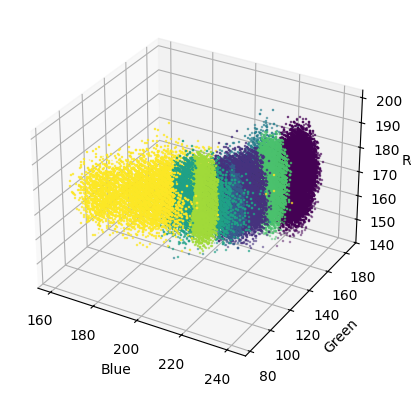

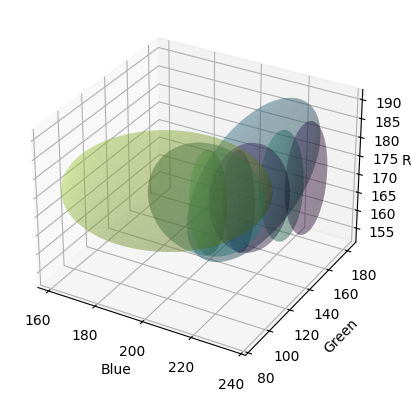

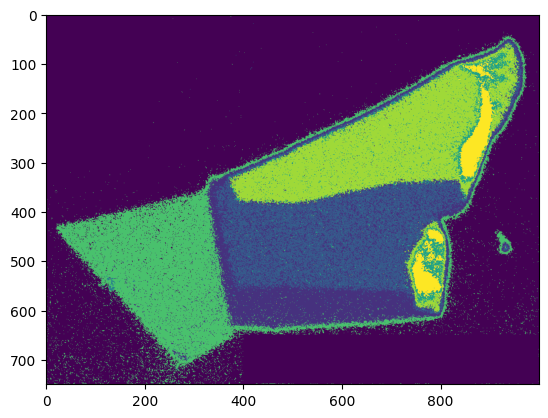

Clustering completed in 328.31 seconds


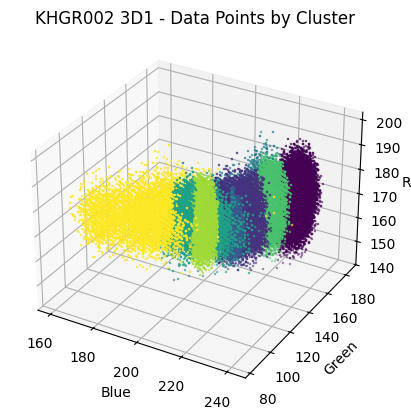

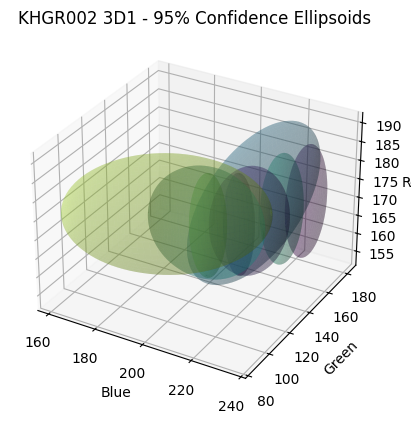

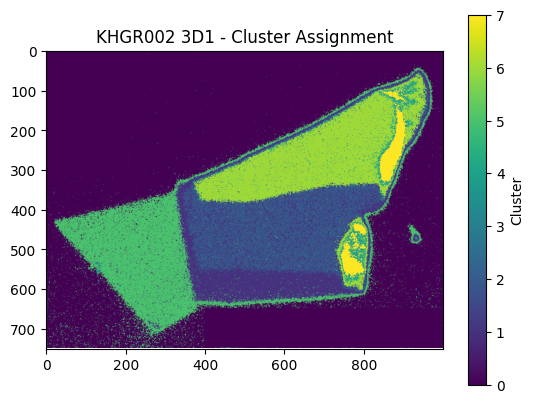

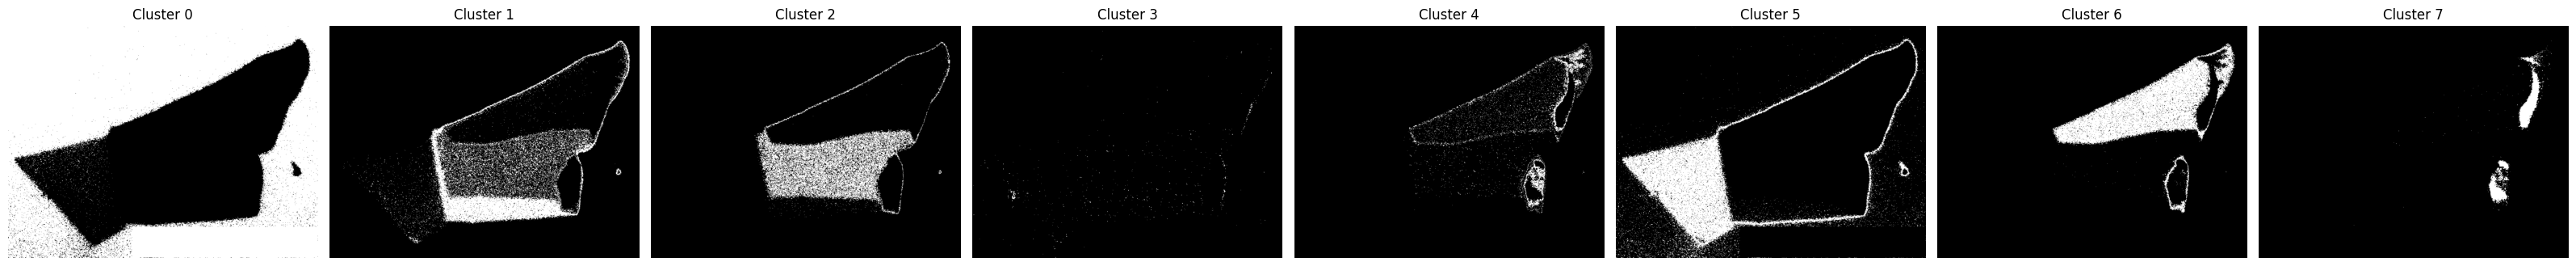

Clustering data saved to clustering_results.npz.
Results saved to clustering_results.npz


In [5]:
def main():
    # Define parameters
    img_file = "./Raw Images/Fig_1a.jpg"  # Replace with your image file
    flake_name = "KHGR002 3D1"
    
    # Optional parameters
    crop = None  # e.g., [100, 500, 200, 600] for [y_min, y_max, x_min, x_max]
    masking = None  # e.g., [[0, 100, 0, 100]] for sections to mask out
    out_file = "clustering_results.npz"
    
    # Algorithm parameters
    min_clusters = 5
    max_clusters = 10
    convergence_param = 1e-6
    
    # Start timer to measure performance improvement
    start_time = time.perf_counter()
    
    # Run the clustering algorithm with GPU acceleration if available
    print(f"Starting clustering on {img_file}...")
    
    args = {'img_file': img_file,
        'flake_name': flake_name,
        'crop': [1100,1850,2300,3300],
        'masking': [[0,300, 0,200], [650,-1, 400,-1]],
        'out_file': "./Monolayer Search/Graphene_on_SiO2_catalog.npz",
        'min_clusters': 8, 'max_clusters': 8}

    results = training(**args)
    
    # End timer
    end_time = time.perf_counter()
    total_time = end_time - start_time
    
    print(f"Clustering completed in {total_time:.2f} seconds")
    
    # Display results
    display_cluster_images(results, flake_name)
    
    # Save results
    save_clustering_data(results, out_file)
    
    print(f"Results saved to {out_file}")
    
    return results

if __name__ == "__main__":
    main()
